In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Suppress TensorFlow oneDNN custom operations warnings
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Load your dataset
df = pd.read_csv("loan_approval_prediction_train.csv")

# Preprocess the data
# Drop unnecessary columns like 'Loan ID' and 'Customer ID'
df = df.drop(["Loan ID", "Customer ID"], axis=1)

# Fill missing values in numeric columns with their median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values in non-numeric columns by filling with "Unknown"
df.fillna("Unknown", inplace=True)

# Create the 'Loan_Status' column based on specified criteria
df["Loan_Status"] = df.apply(
    lambda row: (
        "Approved"
        if (row["Credit Score"] >= 700 and row["Annual Income"] >= 50000)
        else "Not Approved"
    ),
    axis=1,
)

# One-hot encode categorical columns
df = pd.get_dummies(df)

# Split data into features (X) and target (y)
X = df.drop(["Loan_Status_Approved", "Loan_Status_Not Approved"], axis=1)
y = df["Loan_Status_Approved"]  # Use the 'Approved' column as the target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a neural network model with LSTM layers
model = Sequential()
model.add(Input(shape=(X_train_scaled.shape[1], 1)))  # Input shape adjusted for LSTM
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

# Compile the model with RMSprop optimizer
model.compile(optimizer=RMSprop(), loss="binary_crossentropy", metrics=["accuracy"])

# Define early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor="val_loss", patience=5, verbose=1, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1),  # Reshape for LSTM
    y_train,
    validation_data=(
        X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1),
        y_test,
    ),  # Reshape for LSTM
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
)

# Evaluate the model
loss, accuracy = model.evaluate(
    X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1), y_test
)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.8417 - loss: 0.5111 - val_accuracy: 0.8490 - val_loss: 0.4027
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8436 - loss: 0.4328 - val_accuracy: 0.8490 - val_loss: 0.3693
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8420 - loss: 0.3910 - val_accuracy: 0.8490 - val_loss: 0.3221
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8503 - loss: 0.3470 - val_accuracy: 0.8865 - val_loss: 0.2988
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8648 - loss: 0.3096 - val_accuracy: 0.9055 - val_loss: 0.2617
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.8694 - loss: 0.2873 - val_accuracy: 0.9180 - val_loss: 0.2300
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8811 - loss: 0.2606 - val_accuracy: 0.9295 - val_loss: 0.2027
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8997 - loss: 0.2205 - val_accuracy: 0.9420 - v

In [2]:
# Predict probabilities and binary outcomes
y_pred_proba = model.predict(X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1))
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate precision, recall, and F1-score
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1_lstm, _ = precision_recall_fscore_support(
    y_test, y_pred_binary, average="binary"
)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-Score:", f1_lstm)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Test Precision: 0.9911712772218952
Test Recall: 0.9917550058892816
Test F1-Score: 0.9914630556373271


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming y_pred and y_test are continuous variables (not applicable in your case)
mse = mean_squared_error(y_test, y_pred_binary)
mae = mean_absolute_error(y_test, y_pred_binary)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)

Mean Squared Error (MSE): 0.0145
Mean Absolute Error (MAE): 0.0145


In [4]:
from sklearn.metrics import r2_score

# Assuming y_pred and y_test are continuous variables (not applicable in your case)
r2 = r2_score(y_test, y_pred_binary)
n = len(X_test)  # Number of samples
p = X_test.shape[1]  # Number of predictors

adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))

print("Adjusted R^2:", adjusted_r2)

Adjusted R^2: 0.8842305645312764


Confusion Matrix:
 [[ 287   15]
 [  14 1684]]


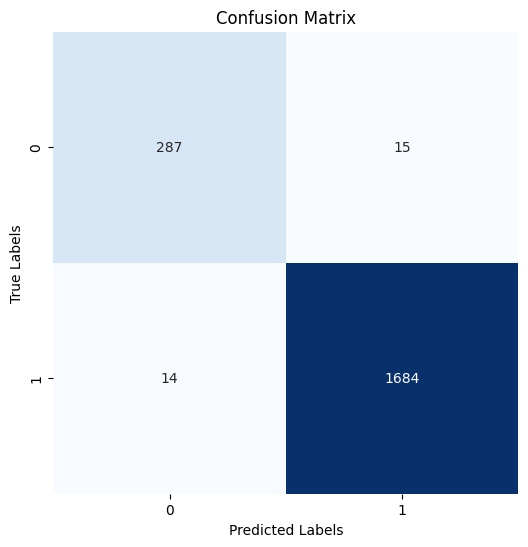

AUC: 0.9978509972776699


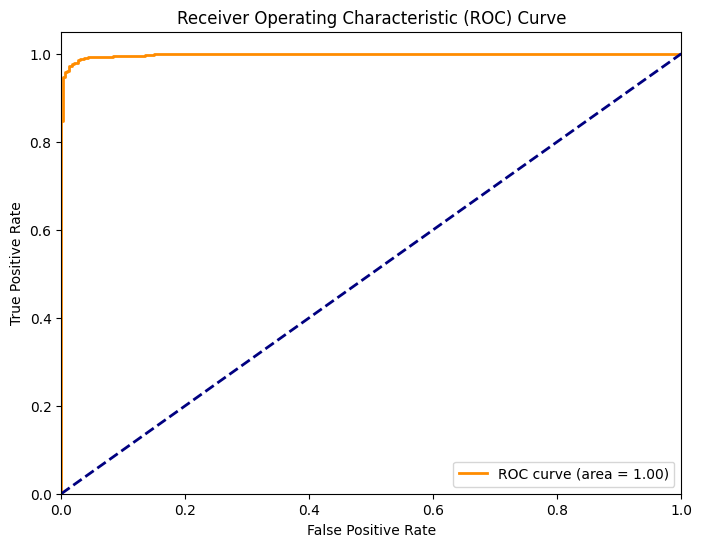

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


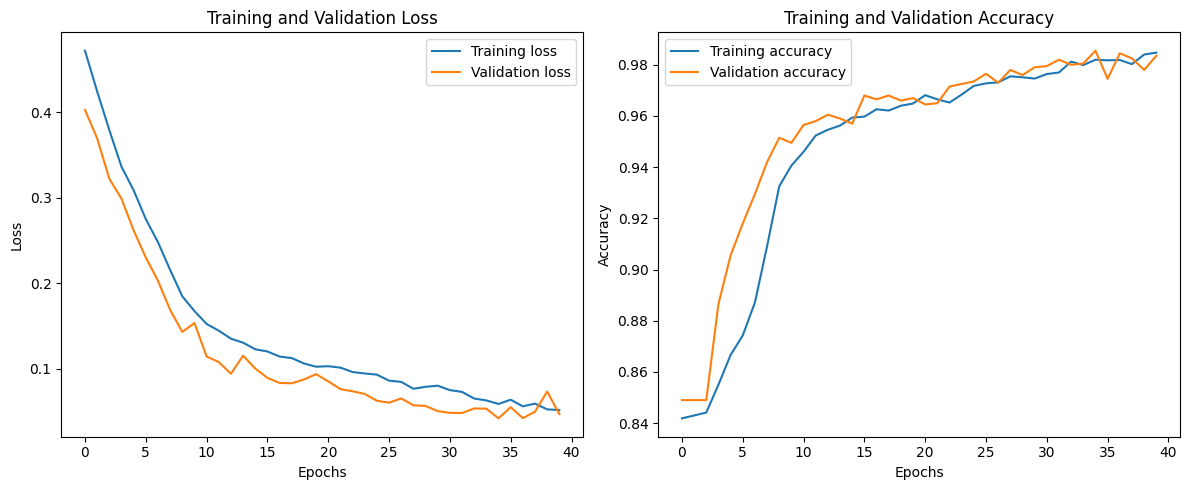

In [5]:
# Import required packages
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Get confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))

# Use the correct metric names found from the inspection step
print(history.history.keys())
# The actual keys will be printed out, update the following variables accordingly
loss_key = "loss"
val_loss_key = "val_loss"
accuracy_key = "accuracy"
val_accuracy_key = "val_accuracy"

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history[loss_key], label="Training loss")
plt.plot(history.history[val_loss_key], label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history[accuracy_key], label="Training accuracy")
plt.plot(history.history[val_accuracy_key], label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Load the dataset
df = pd.read_csv("loan_approval_prediction_train.csv")

# Drop unnecessary columns
df = df.drop(["Loan ID", "Customer ID"], axis=1)

# Fill missing values in numeric columns with their median
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values in non-numeric columns by filling with "Unknown"
df.fillna("Unknown", inplace=True)

# Create the 'Loan_Status' column based on specified criteria
df["Loan_Status"] = df.apply(
    lambda row: (
        "Approved"
        if (row["Credit Score"] >= 700 and row["Annual Income"] >= 50000)
        else "Not Approved"
    ),
    axis=1,
)

# One-hot encode categorical columns
df = pd.get_dummies(df)

# Split data into features (X) and target (y)
X = df.drop(["Loan_Status_Approved", "Loan_Status_Not Approved"], axis=1)
y = df["Loan_Status_Approved"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Scale the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.svm import SVC

# Train SVM model
svm_model = SVC(kernel="rbf", probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Evaluate the SVM model
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

# Print accuracy, precision, and F1-score for KNN model
print("SVM Model:")
print(f"  Accuracy: {accuracy_svm:.4f}")
print(f"  Precision: {precision_svm:.4f}")
print(f"  F1 Score: {f1_svm:.4f}")

SVM Model:
  Accuracy: 0.8445
  Precision: 0.8445
  F1 Score: 0.9157


In [8]:
from sklearn.neighbors import KNeighborsClassifier  # Train KNN model

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Evaluate the KNN model
y_pred_knn = knn_model.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

# Print accuracy, precision, and F1-score for KNN model
print("KNN Model:")
print(f"  Accuracy: {accuracy_knn:.4f}")
print(f"  Precision: {precision_knn:.4f}")
print(f"  F1 Score: {f1_knn:.4f}")

KNN Model:
  Accuracy: 0.9295
  Precision: 0.9257
  F1 Score: 0.9598


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Reshape data for LSTM model
X_train_lstm = X_train_scaled.reshape(-1, X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(-1, X_test_scaled.shape[1], 1)

# Build and train LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train_scaled.shape[1], 1)))
lstm_model.add(Bidirectional(LSTM(32, return_sequences=True)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(16)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(16, activation="relu"))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation="sigmoid"))

lstm_model.compile(
    optimizer=RMSprop(), loss="binary_crossentropy", metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss", patience=5, verbose=1, restore_best_weights=True
)

lstm_model.fit(
    X_train_lstm,
    y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop],
)

# Evaluate the LSTM model
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm)
f1_lstm = f1_score(y_test, y_pred_lstm)

print("LSTM - Accuracy:", accuracy_lstm)
print("LSTM - Precision:", precision_lstm)
print("LSTM - F1 Score:", f1_lstm)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.7791 - loss: 0.5511 - val_accuracy: 0.8443 - val_loss: 0.4225
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8469 - loss: 0.4433 - val_accuracy: 0.8443 - val_loss: 0.3907
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8444 - loss: 0.4180 - val_accuracy: 0.8450 - val_loss: 0.3498
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8535 - loss: 0.3792 - val_accuracy: 0.8677 - val_loss: 0.3096
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8730 - loss: 0.3342 - val_accuracy: 0.9007 - val_loss: 0.2838
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8890 - loss: 0.2986 - val_accuracy: 0.9047 - val_loss: 0.2531
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.8948 - loss: 0.2801 - val_accuracy: 0.9155 - val_loss: 0.2230
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9033 - loss: 0.2619 - val_accuracy: 0.9258 - v

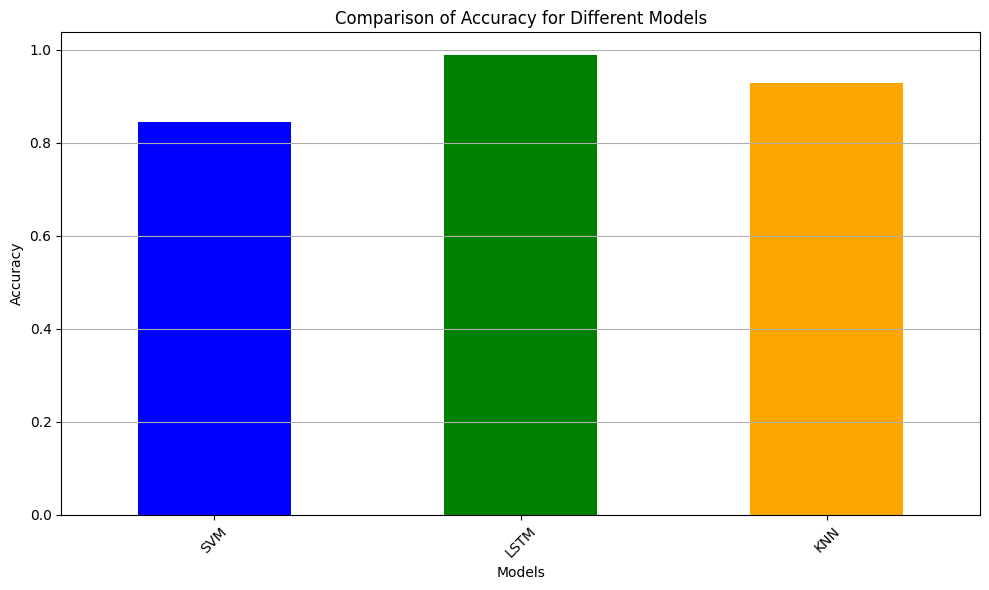

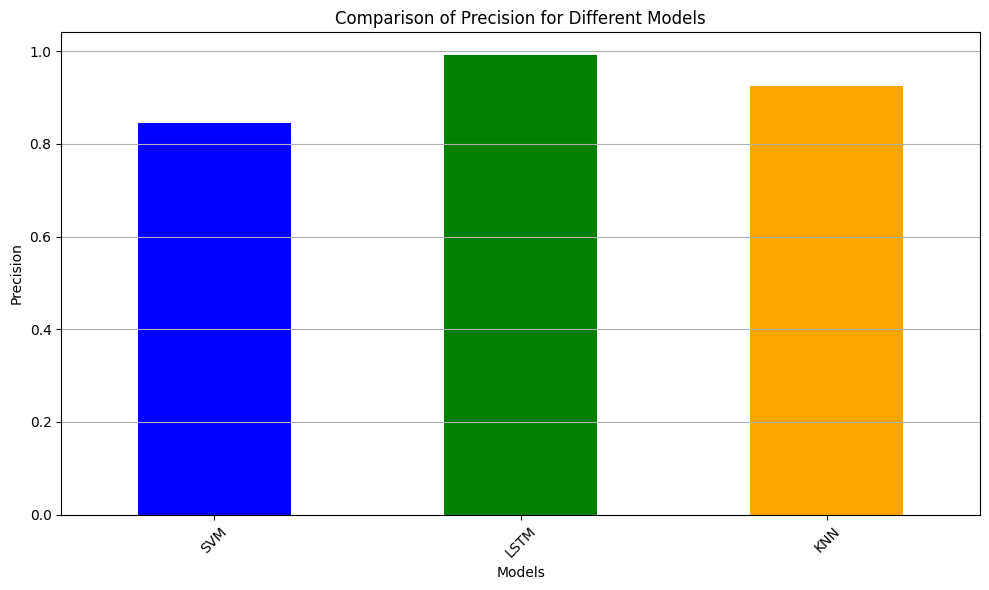

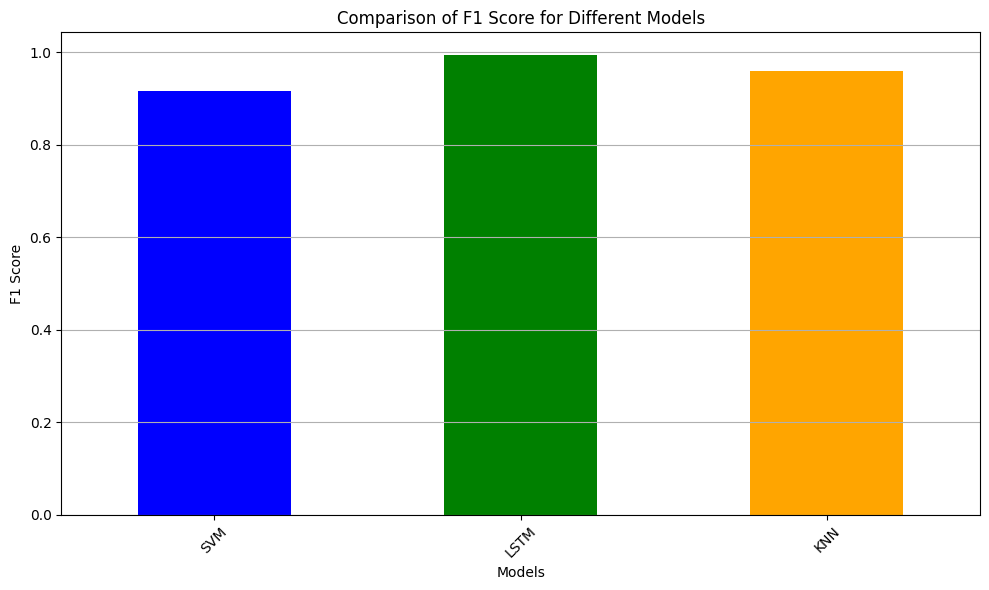

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

metrics_dict = {
    "SVM": {"accuracy": accuracy_svm, "precision": precision_svm, "f1_score": f1_svm},
    "LSTM": {
        "accuracy": accuracy_lstm,
        "precision": precision_lstm,
        "f1_score": f1_lstm,
    },
    "KNN": {"accuracy": accuracy_knn, "precision": precision_knn, "f1_score": f1_knn},
}

# Convert dictionary to DataFrame for easier plotting
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient="index")

# Plot comparison of accuracy for all models
plt.figure(figsize=(10, 6))
metrics_df["accuracy"].plot(kind="bar", color=["blue", "green", "orange"])
plt.title("Comparison of Accuracy for Different Models")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Plot comparison of precision for all models
plt.figure(figsize=(10, 6))
metrics_df["precision"].plot(kind="bar", color=["blue", "green", "orange"])
plt.title("Comparison of Precision for Different Models")
plt.xlabel("Models")
plt.ylabel("Precision")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Plot comparison of F1-score for all models
plt.figure(figsize=(10, 6))
metrics_df["f1_score"].plot(kind="bar", color=["blue", "green", "orange"])
plt.title("Comparison of F1 Score for Different Models")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [11]:
# Create a DataFrame for model comparison
comparison_df = pd.DataFrame(
    {
        "Model": ["SVM", "LSTM", "KNN"],
        "Accuracy": [accuracy_svm, accuracy_lstm, accuracy_knn],
        "Precision": [precision_svm, precision_lstm, precision_knn],
        "F1 Score": [f1_svm, f1_lstm, f1_knn],
    }
)

# Display the comparison table
print(comparison_df)

  Model  Accuracy  Precision  F1 Score
0   SVM   0.84450   0.844461  0.915672
1  LSTM   0.98825   0.991150  0.993055
2   KNN   0.92950   0.925722  0.959783
